In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import tree
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
import visualkeras
import tensorflow as tf
tf.data.experimental.enable_debug_mode()
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm_notebook
from sklearn.tree import export_graphviz
from collections import defaultdict
from sklearn.metrics import classification_report



In [2]:
og_df = pd.read_csv('all_seasons.csv')

In [3]:
preferred_team = str(input('Which team would you like to investigate: '))


def team_selection(pref, df):
    if pref in df.HomeTeam.unique():
        df = df[df.HomeTeam == pref]
        return df
    else:
        print('Not a team.')

In [4]:
new_df = team_selection(preferred_team,og_df)

In [5]:
factors = ['ShotDist','TimeoutTeam','Substitution', 'Shooter',
           'Rebounder', 'Blocker','Fouler',
          'ReboundType','ViolationPlayer',
          'FreeThrowShooter','TurnoverPlayer']

fact_cols = [col + str((i // 11) % 10 + 1) for i, col in enumerate(factors * 10)]
fact_cols.append('class')

In [6]:
new_df['ShotDist'] = new_df.ShotDist.apply(lambda x: 'close' if x <= 10 else '3pt' if x >= 22 else 'mid' if pd.notna(x) else x)

new_df['TimeoutTeam'] = new_df.apply(
    lambda row: 'timeout_home' if pd.notna(row['TimeoutTeam']) and row['TimeoutTeam'] == row['HomeTeam'] 
    else 'timeout_away' if pd.notna(row['TimeoutTeam']) 
    else row['TimeoutTeam'], 
    axis=1
)

new_df['Shooter'] = new_df.apply(lambda row: 'shooter_home' if pd.notna(row['Shooter']) and pd.notna(row['HomePlay'])
                                     else 'shooter_away' if pd.notna(row['Shooter']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

new_df['Rebounder'] = new_df.apply(lambda row: 'rebounder_home' if pd.notna(row['Rebounder']) and pd.notna(row['HomePlay'])
                                     else 'rebounder_away' if pd.notna(row['Rebounder']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

new_df['Blocker'] = new_df.apply(lambda row: 'blocker_home' if pd.notna(row['Blocker']) and pd.notna(row['HomePlay'])
                                     else 'blocker_away' if pd.notna(row['Blocker']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

new_df['Fouler'] = new_df.apply(lambda row: 'fouler_home' if pd.notna(row['Fouler']) and pd.notna(row['HomePlay'])
                                     else 'fouler_away' if pd.notna(row['Fouler']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)


new_df['ViolationPlayer'] = new_df.apply(lambda row: 'violator_home' if pd.notna(row['ViolationPlayer']) and pd.notna(row['HomePlay'])
                                     else 'violator_away' if pd.notna(row['ViolationPlayer']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

new_df['FreeThrowShooter'] = new_df.apply(lambda row: 'ft_home' if pd.notna(row['FreeThrowShooter']) and pd.notna(row['HomePlay'])
                                     else 'ft_away' if pd.notna(row['FreeThrowShooter']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

new_df['TurnoverPlayer'] = new_df.apply(lambda row: 'to_player_home' if pd.notna(row['TurnoverPlayer']) and pd.notna(row['HomePlay'])
                                     else 'to_player_away' if pd.notna(row['TurnoverPlayer']) and pd.notna(row['AwayPlay'])
                                     else np.nan,
                                     axis=1)

new_df['Substitution'] = new_df.apply(lambda row: 'sub_home' if pd.notna(row['EnterGame']) and pd.notna(row['HomePlay'])
                                              else 'sub_away' if pd.notna(row['EnterGame']) and pd.notna(row['AwayPlay'])
                                              else np.nan,
                                              axis=1)



C:\Users\gsevr\AppData\Local\Temp\ipykernel_11384\2851057865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['ShotDist'] = new_df.ShotDist.apply(lambda x: 'close' if x <= 10 else '3pt' if x >= 22 else 'mid' if pd.notna(x) else x)
C:\Users\gsevr\AppData\Local\Temp\ipykernel_11384\2851057865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['TimeoutTeam'] = new_df.apply(
C:\Users\gsevr\AppData\Local\Temp\ipykernel_11384\2851057865.py:10: SettingWithCopyWarning: 
A value is trying to be set

In [7]:
def home_runner(data):
    global home_runs
    run = []
    home_runs = []
    for idx in data.index:
        if data.at[idx,'HomePlay'] is not np.nan:
                if 'makes' in data.at[idx,'HomePlay']:
                    run.append(idx)
        elif data.at[idx,'AwayPlay'] is not np.nan:
                if 'makes' in data.at[idx,'AwayPlay']:
                    run.clear()
        if len(run) == 4:
            home_runs.append(run.copy())
            run.clear()
    return home_runs
                

home_runner(new_df)



def away_runner(data):
    global away_runs
    run = []
    away_runs = []
    for idx in data.index:
        if data.at[idx,'AwayPlay'] is not np.nan:
                if 'makes' in data.at[idx,'AwayPlay']:
                    run.append(idx)
        elif data.at[idx,'HomePlay'] is not np.nan:
                if 'makes' in data.at[idx,'HomePlay']:
                    run.clear()
        if len(run) == 4:
            away_runs.append(run.copy())
            run.clear()
    return away_runs

away_runner(new_df)

all_runs = []
all_runs.extend(home_runs)
all_runs.extend(away_runs)


In [8]:
new_df = new_df[factors]


In [9]:
def runs_iter(data, runs):
    global runs_df
    runs_df = pd.DataFrame()
    for run in runs:
        a = data.loc[run[0]-10:run[0]-1, factors].values.ravel()
        a = np.append(a,1)
        runs_df = pd.concat([runs_df,pd.DataFrame([a.copy()])])
    return runs_df

runs_iter(new_df, home_runs)
runs_df.columns = fact_cols
runs_df

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,1.0
0,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
0,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,1.0
0,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,1.0
0,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,reboun

In [10]:
def no_runs_preprocessing(data, runs):
    global no_runs_split
    
    # find the first index of a run
    r = [i[0] for i in runs]  

    # create a list of runs
    r_x = []
    for num in r:
        r_x.extend(range(num - 10, num + 1))

    # mask the df without runs
    no_runs_df = data[~data.index.isin(r_x)].reset_index(drop=True)

    # segment the df and keep those that are length of 10
    segment_size = 10
    segments = len(no_runs_df) // segment_size

    no_runs_split = np.array_split(no_runs_df, segments)

    no_runs_split = [x for x in no_runs_split if len(x) != 11]

    return no_runs_split

In [11]:
def no_runs_optimized(data, factors, fact_cols):
    global no_runs_df
    no_runs_df = pd.DataFrame([np.append(segment.loc[:, factors].values.ravel(), int(0)) for segment in data])
    no_runs_df.columns = fact_cols
    return no_runs_df

no_runs_optimized(no_runs_preprocessing(new_df, home_runs), factors, fact_cols)

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,0
1,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,NaN,timeout_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [12]:
combined_df = pd.concat([runs_df,no_runs_df],ignore_index=True)
combined_df

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,mid,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,1.0
1,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,offensive,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,offensive,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3pt,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_away,NaN,NaN,defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_away,1.0
3,NaN,NaN,sub_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rebounder_home,NaN,NaN,defensive,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,3pt,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fouler_home,NaN,NaN,NaN,NaN,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,fouler_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_player_home,mid,NaN,NaN,shooter_away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,close,NaN,NaN,shooter_home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,reboun

In [13]:
combined_df.to_csv(str(preferred_team)+'_runs.csv', index=False)
combined_df = pd.read_csv('ATL_runs.csv')


In [14]:
df = pd.DataFrame()
encoders = []

for column in combined_df.columns[:-1]:
    le = LabelEncoder()
    encoders.append(le)
    df[column] = le.fit_transform(combined_df[column])

C:\Users\gsevr\AppData\Local\Temp\ipykernel_11384\172710995.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = le.fit_transform(combined_df[column])
C:\Users\gsevr\AppData\Local\Temp\ipykernel_11384\172710995.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = le.fit_transform(combined_df[column])
C:\Users\gsevr\AppData\Local\Temp\ipykernel_11384\172710995.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

In [15]:
df = pd.concat([df,combined_df.iloc[:,-1]],axis=1)
df

,ShotDist1,TimeoutTeam1,Substitution1,Shooter1,Rebounder1,Blocker1,Fouler1,ReboundType1,ViolationPlayer1,FreeThrowShooter1,TurnoverPlayer1,ShotDist2,TimeoutTeam2,Substitution2,Shooter2,Rebounder2,Blocker2,Fouler2,ReboundType2,ViolationPlayer2,FreeThrowShooter2,TurnoverPlayer2,ShotDist3,TimeoutTeam3,Substitution3,Shooter3,Rebounder3,Blocker3,Fouler3,ReboundType3,ViolationPlayer3,FreeThrowShooter3,TurnoverPlayer3,ShotDist4,TimeoutTeam4,Substitution4,Shooter4,Rebounder4,Blocker4,Fouler4,ReboundType4,ViolationPlayer4,FreeThrowShooter4,TurnoverPlayer4,ShotDist5,TimeoutTeam5,Substitution5,Shooter5,Rebounder5,Blocker5,Fouler5,ReboundType5,ViolationPlayer5,FreeThrowShooter5,TurnoverPlayer5,ShotDist6,TimeoutTeam6,Substitution6,Shooter6,Rebounder6,Blocker6,Fouler6,ReboundType6,ViolationPlayer6,FreeThrowShooter6,TurnoverPlayer6,ShotDist7,TimeoutTeam7,Substitution7,Shooter7,Rebounder7,Blocker7,Fouler7,ReboundType7,ViolationPlayer7,FreeThrowShooter7,TurnoverPlayer7,ShotDist8,TimeoutTeam8,Substitution8,Shooter8,Rebounder8,Blocker8,Fouler8,ReboundType8,ViolationPlayer8,FreeThrowShooter8,TurnoverPlayer8,ShotDist9,TimeoutTeam9,Substitution9,Shooter9,Rebounder9,Blocker9,Fouler9,ReboundType9,ViolationPlayer9,FreeThrowShooter9,TurnoverPlayer9,ShotDist10,TimeoutTeam10,Substitution10,Shooter10,Rebounder10,Blocker10,Fouler10,ReboundType10,ViolationPlayer10,FreeThrowShooter10,TurnoverPlayer10,class
0,3,2,2,2,2,2,0,2,2,2,2,4,2,2,2,2,2,2,2,2,0,2,2,2,2,1,2,2,2,2,2,2,2,3,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,3,2,2,1,2,2,2,2,2,2,2,3,2,2,2,0,2,2,0,2,2,2,2,2,2,0,2,2,2,2,2,2,2,4,2,2,2,2,2,2,2,2,2,1,4,2,2,2,2,2,2,2,2,2,0,1.0
1,3,2,2,2,0,2,2,1,2,2,2,2,2,2,0,2,2,2,2,2,2,2,4,2,2,2,0,2,2,1,2,2,2,2,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,4,2,2,2,2,2,2,2,2,1,2,3,2,2,2,1,2,2,1,2,2,2,4,2,0,2,2,2,2,2,2,2,2,4,2,1,2,2,2,2,2,2,2,2,4,2,1,2,2,2,2,2,2,2,2,1.0
2,3,2,1,2,2,2,2,2,2,2,2,4,2,1,2,2,2,2,2,2,2,2,4,2,0,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,4,2,2,2,2,2,2,2,2,1,2,2,2,2,0,2,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,4,2,2,2,0,2,2,0,2,2,2,4,2,2,2,2,2,2,2,2,2,0,1.0
3,3,2,1,2,2,2,2,2,2,2,2,4,2,2,2,2,2,2,2,2,1,2,4,2,2,2,2,2,0,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,4,2,2,2,2,2,2,2,2,2,1,1,2,2,0,2,2,2,2,2,2,2,4,2,2,2,2,2,1,2,2,2,2,1.0
4,3,2,2,2,2,2,0,2,2,2,2,4,2,2,2,2,2,2,2,2,0,2,4,2,0,2,2,2,2,2,2,2,2,4,2,0,2,2,2,2,2,2,2,2,3,2,2,2,2,2,2,2,2,0,2,4,2,2,2,2,2,2,2,2,2,1,2,2,2,0,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,4,2,2,2,0,2,2,0,2,2,2,1,2,2,0,2,2,2,2,2,2,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,1,2,2,0,2,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,4,2,2,2,0,2,2,0,2,2,2,1,2,2,0,2,2,2,2,2,2,2,3,2,2,2,1,2,2,0,2,2,2,4,2,2,2,2,2,1,2,2,2,2,3,2,2,2,2,2,2,2,2,1,2,4,2,1,2,2,2,2,2,2,2,2,4,2,2,2,2,2,2,2,2,1,2,1,2,2,0,2,2,2,2,2,2,2,0.0
9738,0,2,2,1,2,2,2,2,2,2,2,4,2,2,2,0,2,2,0,2,2,2,1,2,2,0,2,2,2,2,2,2,2,4,2,2,2,1,2,2,0,2,2,2,3,2,2,2,2,2,2,2,2,2,1,2,2,2,0,2,2,2,2,2,2,2,3,2,2,2,2,2,0,2,2,2,2,4,2,2,2,2,2,2,2,2,0,2,2,2,2,1,2,2,2,2,2,2,2,4,2,2,2,2,2,2,2,2,2,0,0.0
9739,0,2,2,1,2,2,2,2,2,2,2,4,2,2,2,0,2,2,0,2,2,2,4,0,2,2,2,2,2,2,2,2,2,4,2,0,2,2,2,2,2,2,2,2,3,2,2,2,2,2,0,2,2,2,2,4,2,2,2,2,2,2,2,2,0,2,3,2,2,2,2,2,2,2,2,0,2,4,2,2,2,2,2,2,2,2,2,1,4,2,2,2,2,2,0,2,2,2,2,4,2,2,2,2,2,2,2,2,0,2,0.0
9740,3,2,2,2,2,2,2,2,2,0,2,4,2,2,2,1,2,2,0,2,2,2,4,1,2,2,2,2,2,2,2,2,2,4,2,0,2,2,2,2,2,2,2,2,3,2,2,2,2,2,1,2,2,2,2,4,2,2,2,2,2,2,2,2,1,2,3,2,0,2,2,2,2,2,2,2,2,4,2,2,2,2,2,2,2,2,1,2,4,0,2,2,2,2,2,2,2,2,2,4,2,1,2,2,2,2,2,2,2,2,0.0


In [16]:
model = load_model('pretrained_model_le.keras')

In [17]:
X = df.iloc[:,:-1].values.reshape(-1,11,10)

In [18]:
preds = model.predict(X)

305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [19]:
preds = np.argmax(preds,axis=1)

In [20]:
df['class'] = df['class'].fillna(0) # to work for now

print(classification_report(df.iloc[:,-1], preds))

              precision    recall  f1-score   support

         0.0       1.00      0.58      0.73      9192
         1.0       0.12      0.95      0.21       550

    accuracy                           0.60      9742
   macro avg       0.56      0.77      0.47      9742
weighted avg       0.95      0.60      0.71      9742



In [21]:
def sequence_mining(team, opponent, df):
    global events_idx
    combined_df = df
    combined_df = combined_df.replace({str(team):'same', str(opponent):'other'}, regex=True)
    
    df = pd.DataFrame()
    encoders = []

    for column in combined_df.columns[:-1]:
        le = LabelEncoder()
        encoders.append(le)
        df[column] = le.fit_transform(combined_df[column])

    df = pd.concat([df, combined_df.iloc[:, -1]], axis=1)

    undersample_len = len(df[df['class'] == 1])

    undersample_df = df[df['class'] == 0].sample(n=undersample_len, random_state=43)
    df = pd.concat([df[df['class'] == 1], undersample_df])

    events_idx = {}
    
    sequence_mining_html = ""
    for j, event in zip(range(12, 112, 11), range(10, 0, -1)):
        a = combined_df.iloc[:, -j:-1][combined_df['class'] == 1]

        # Count occurrences of each row
        row_counts = defaultdict(int)
        for i in range(len(a)):
            row_tuple = tuple(a.iloc[i])
            row_counts[row_tuple] += 1

        # Row with the maximum count
        max_count = 0
        mc_row = None
        for row, count in row_counts.items():
            if count > max_count:
                max_count = count
                mc_row = row

        # Find all indices of the rows that match the row with the maximum count
        mc_indices = a.apply(lambda row: tuple(row) == mc_row, axis=1)
        mc_indices = mc_indices[mc_indices].index.tolist()

        events_idx[event] = mc_indices

        sequence_mining_html += f"<p><strong>Event: {event}</strong></p>"
        sequence_mining_html += f"<p>Indices: {mc_indices[0]}, Max Count: {max_count}</p>"
        sequence_mining_html += f"<table class='table table-striped'>{combined_df.iloc[mc_indices[0], -j:-1].to_frame().dropna().T.to_html()}</table>"
    
    return sequence_mining_html

In [22]:
sequence_mining('home','away',combined_df)

C:\Users\gsevr\AppData\Local\Temp\ipykernel_11384\2444910744.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = le.fit_transform(combined_df[column])
C:\Users\gsevr\AppData\Local\Temp\ipykernel_11384\2444910744.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column] = le.fit_transform(combined_df[column])
C:\Users\gsevr\AppData\Local\Temp\ipykernel_11384\2444910744.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

'<p><strong>Event: 10</strong></p><p>Indices: 3, Max Count: 155</p><table class=\'table table-striped\'><table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Fouler10</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>3</th>\n      <td>fouler_same</td>\n    </tr>\n  </tbody>\n</table></table><p><strong>Event: 9</strong></p><p>Indices: 17, Max Count: 31</p><table class=\'table table-striped\'><table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Rebounder9</th>\n      <th>ReboundType9</th>\n      <th>Fouler10</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>17</th>\n      <td>rebounder_same</td>\n      <td>defensive</td>\n      <td>fouler_same</td>\n    </tr>\n  </tbody>\n</table></table><p><strong>Event: 8</strong></p><p>Indices: 17, Max Count: 13</p><table class=\'table table-striped\'><table border="1" class="dataframe">\n  <thead>\n    <tr style="

8

In [44]:
def performers(events_idx, original_df, event=2):
    features = ['TimeoutTeam','EnterGame',
                'LeaveGame','Shooter',
                'Rebounder', 'Blocker','Fouler',
                'ReboundType','ViolationPlayer',
                'FreeThrowShooter','TurnoverPlayer']
    
    desired_event = sorted(events_idx, key=lambda k: len(events_idx[k]), reverse=True)[event]
    l = []
    a = original_df.loc[events_idx[desired_event]][features]
    for factor in features:
        l.append(a[factor].value_counts())
        value_counts = a[factor].value_counts()
        sns.barplot(x=value_counts.index,y=value_counts.values)
        plt.xticks(rotation=45)
    return l

In [45]:
features = ['TimeoutTeam','EnterGame',
                'LeaveGame','Shooter',
                'Rebounder', 'Blocker','Fouler',
                'ReboundType','ViolationPlayer',
                'FreeThrowShooter','TurnoverPlayer']

In [46]:
og_df.loc[events_idx[10]][features]

,TimeoutTeam,EnterGame,LeaveGame,Shooter,Rebounder,Blocker,Fouler,ReboundType,ViolationPlayer,FreeThrowShooter,TurnoverPlayer
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K. Bazemore - bazemke01
9,NaN,NaN,NaN,A. Drummond - drumman01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,A. Drummond - drumman01,NaN,NaN,defensive,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,M. Morris - morrima03,NaN,NaN,defensive,NaN,NaN,NaN
26,NaN,NaN,NaN,J. Teague - teaguje01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
543,NaN,NaN,NaN,A. Brooks - brookaa01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
544,NaN,NaN,NaN,NaN,T. Thompson - thomptr01,NaN,NaN,defensive,NaN,NaN,NaN
549,NaN,NaN,NaN,NaN,NaN,NaN,J. Smith - smithjr01,NaN,NaN,NaN,NaN
557,NaN,D. Rose - rosede01,A. Brooks - brookaa01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import time

def performers(events_idx, original_df, event=2):
    features = ['TimeoutTeam','EnterGame',
                'LeaveGame','Shooter',
                'Rebounder', 'Blocker','Fouler',
                'ReboundType','ViolationPlayer',
                'FreeThrowShooter','TurnoverPlayer']
    
    # Find the event with the second maximum length
    desired_event = sorted(events_idx, key=lambda k: len(events_idx[k]), reverse=True)[event]
    
    l = []
    a = original_df.loc[events_idx[desired_event]][features]
    
    for factor in features:
        value_counts = a[factor].value_counts()
        l.append(value_counts)
        
        # Create a barplot for each factor's value counts
        plt.figure(figsize=(10, 6))
        sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")
        plt.title(f'Value Counts for {factor} in Event {desired_event}')
        plt.xlabel(factor)
        plt.ylabel('Counts')
        plt.xticks(rotation=45)
        plt.show()
        
        # Add a small pause to ensure plots render sequentially
        time.sleep(0.5)
    
    return l


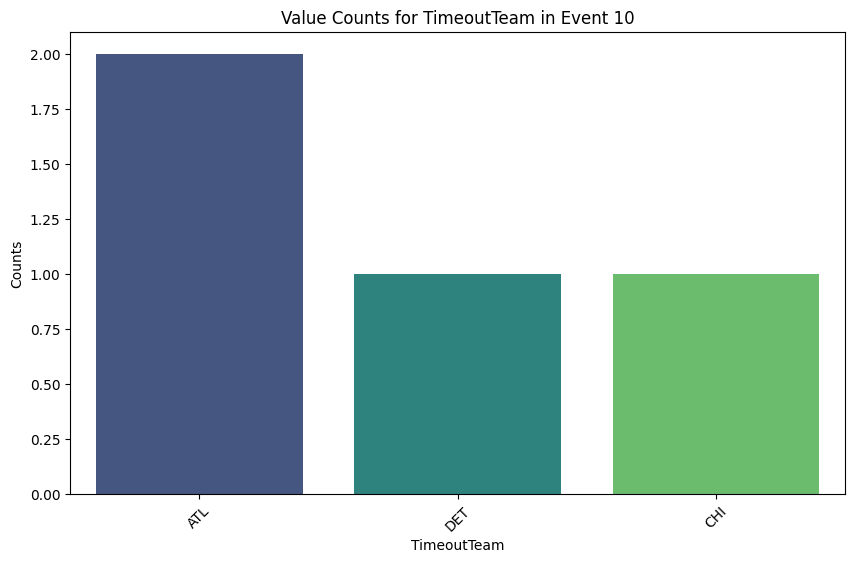

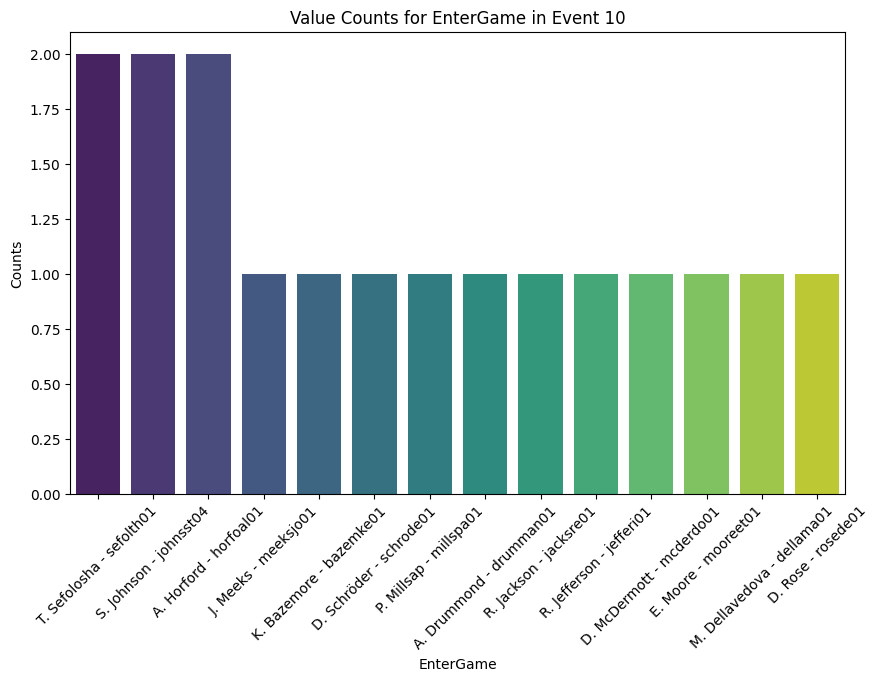

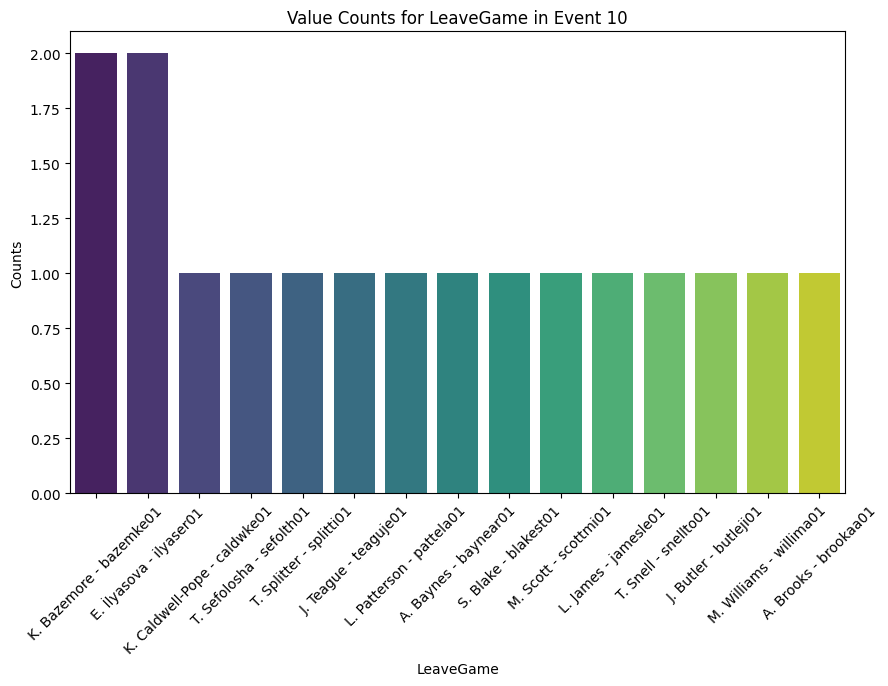

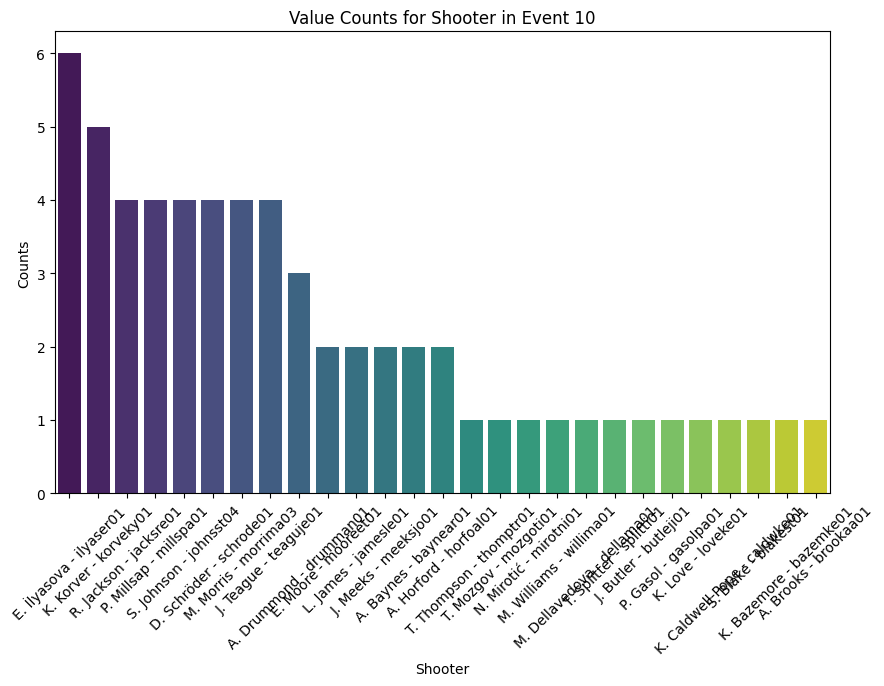

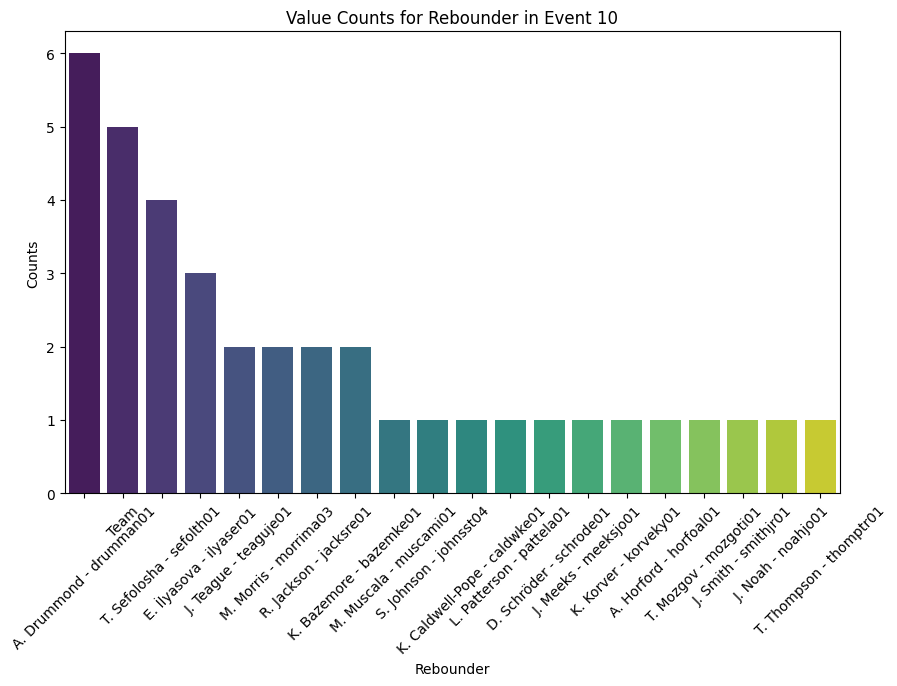

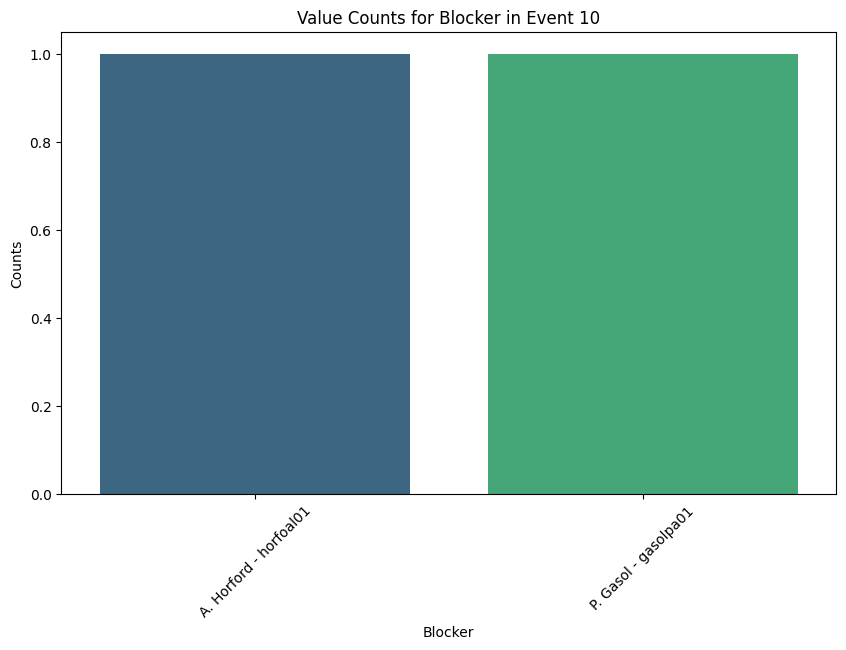

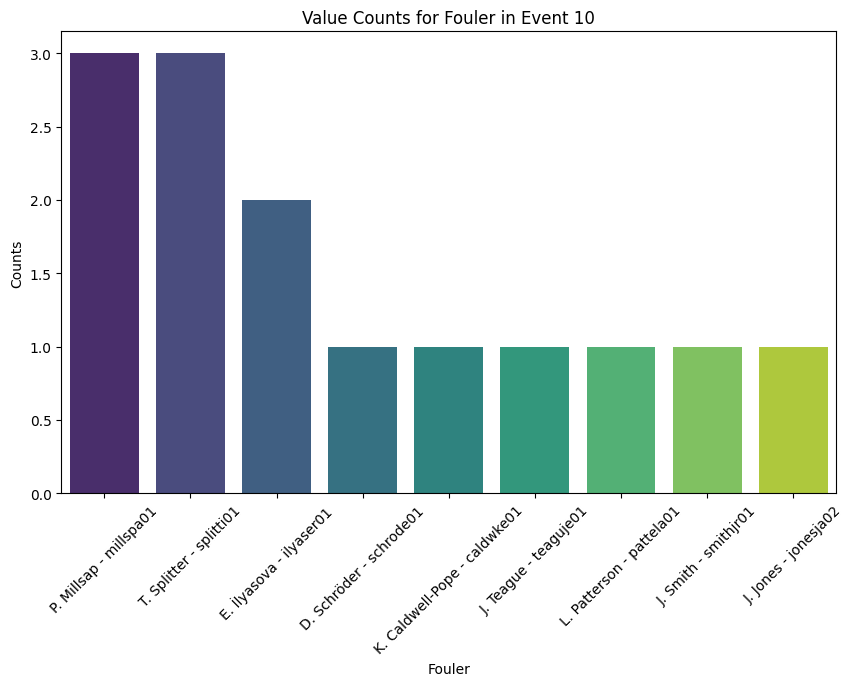

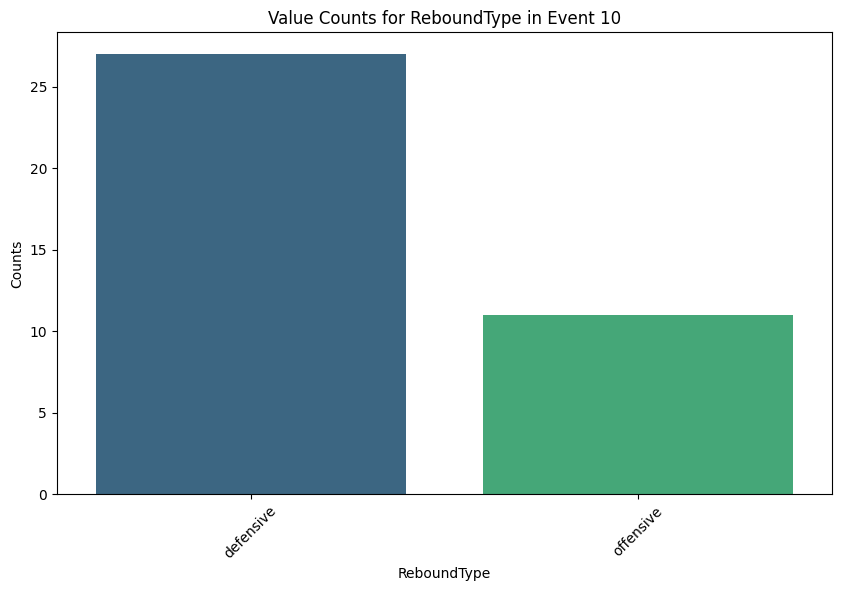

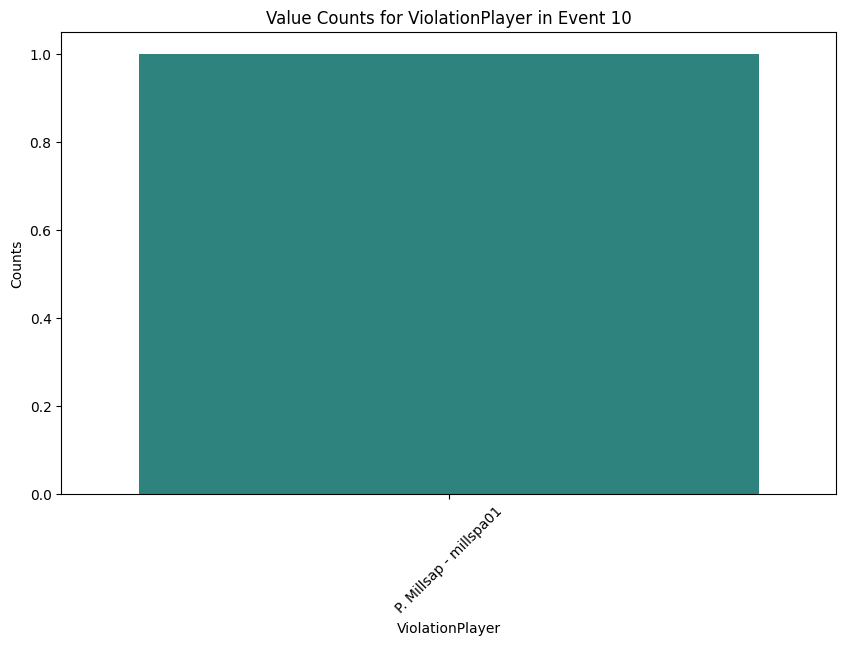

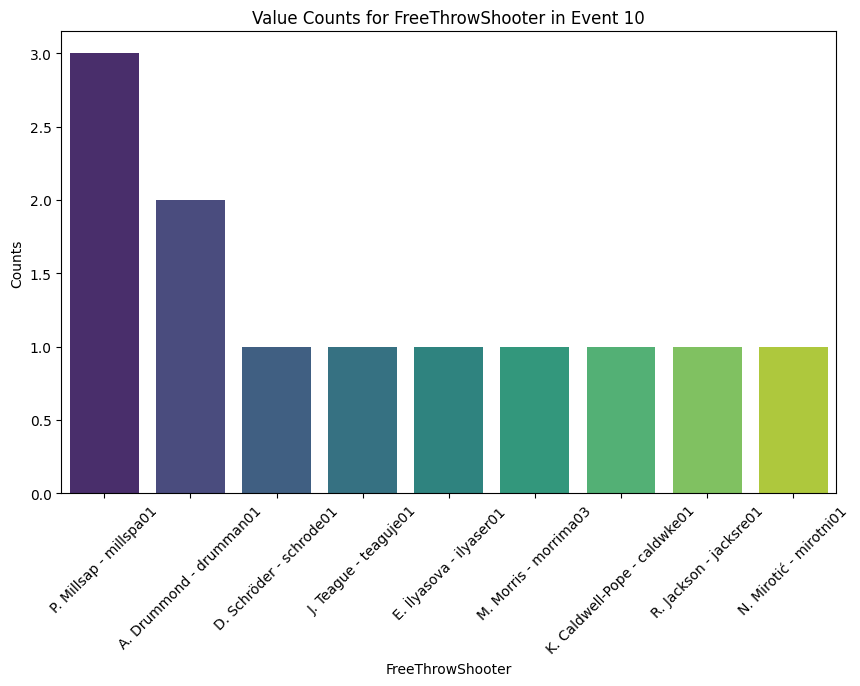

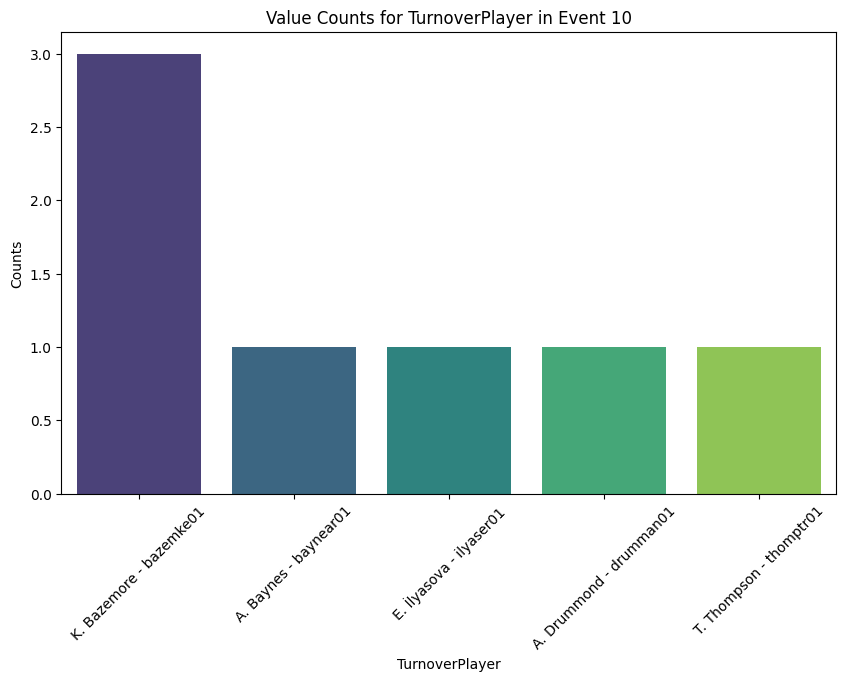

[TimeoutTeam
 ATL    2
 DET    1
 CHI    1
 Name: count, dtype: int64,
 EnterGame
 T. Sefolosha - sefolth01      2
 S. Johnson - johnsst04        2
 A. Horford - horfoal01        2
 J. Meeks - meeksjo01          1
 K. Bazemore - bazemke01       1
 D. Schröder - schrode01       1
 P. Millsap - millspa01        1
 A. Drummond - drumman01       1
 R. Jackson - jacksre01        1
 R. Jefferson - jefferi01      1
 D. McDermott - mcderdo01      1
 E. Moore - mooreet01          1
 M. Dellavedova - dellama01    1
 D. Rose - rosede01            1
 Name: count, dtype: int64,
 LeaveGame
 K. Bazemore - bazemke01         2
 E. İlyasova - ilyaser01         2
 K. Caldwell-Pope - caldwke01    1
 T. Sefolosha - sefolth01        1
 T. Splitter - splitti01         1
 J. Teague - teaguje01           1
 L. Patterson - pattela01        1
 A. Baynes - baynear01           1
 S. Blake - blakest01            1
 M. Scott - scottmi01            1
 L. James - jamesle01            1
 T. Snell - snellto01           

In [49]:
performers(events_idx,og_df,event=0)